In [4]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import LineSourceSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator
from electronTransportCode.ProjectUtils import ERE
from electronTransportCode.ParticleModel import LineSourceParticle
from electronTransportCode.ProjectUtils import E_THRESHOLD
from electronTransportCode.Material import unitDensityMaterial
%matplotlib widget

### Set up all objects
Either do simulation, or load objects from data file

In [7]:
SEED: int = 4  # Random number generator seed
SIM: bool = False

if SIM:
    # Set up initial conditions
    eSource: float = 1.0
    lineSourceSim = LineSourceSimulation(minEnergy=0, eSource=eSource, rngSeed=SEED)

    # Set up simulation domain
    xmin = -1.0; xmax = 1.0; xbins = 100
    simDomain = SimulationDomain(xmin, xmax, xmin, xmax, xbins, xbins, material=unitDensityMaterial)

    # Set up dose estimator
    Ebins = 10
    fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)

    # Set up particle
    particle = LineSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

    # Set up particle tracer
    particleTracer = AnalogParticleTracer(particle=particle, simOptions=lineSourceSim, simDomain=simDomain)
    
    NB_PARTICLES = 10
    particleTracer(nbParticles=NB_PARTICLES, estimator=fluenceEstimator)
    print(f'Average amount of events: {particleTracer.averageNbCollisions}')
else:
    with open('data/particleTracer.pkl', 'rb') as file:
        particleTracer = pickle.load(file)
        
    with open('data/fluenceEstimator.pkl', 'rb') as file:
        fluenceEstimator = pickle.load(file)

    particle = particleTracer.particle
    simDomain = particleTracer.simDomain
    lineSourceSim = particleTracer.simOptions

    eSource= lineSourceSim.eSource
    xmin = simDomain.xmin
    xmax = simDomain.xmax
    xbins = simDomain.xbins
    Ebins = fluenceEstimator.Ebins

In [8]:
fluenceEstimator.scoreMatrix.sum()

499999.9999999922

In [6]:
# Compute exact solution at E = 0 (t = 1)
import exactSolution
solRes = 101
xSolIndex = int((solRes-1)/2)
solxmax = 1.0; solxmin = -1.0
xs = np.linspace(solxmin, solxmax, solRes)
ys = np.linspace(solxmin, solxmax, solRes)
xv, _ = np.meshgrid(xs, ys)
res = np.zeros_like(xv)
for i1, x1 in enumerate(xs):
    for i2, y1 in enumerate(ys):
        if np.power(x1, 2) + np.power(y1, 2) < 1.0:
            res[i1, i2] = exactSolution.lineSourceSolution(x1, y1, 0.0, eSource)


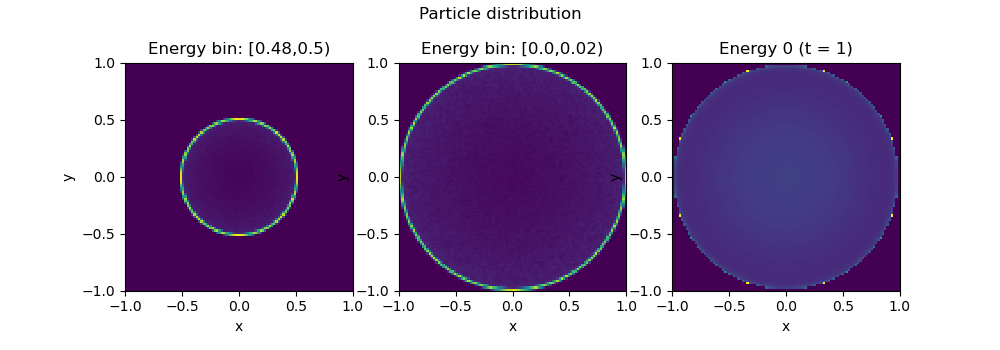

In [9]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
finalFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (xbins, xbins)))
initFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (xbins, xbins)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('Particle distribution')

roundDigits = 3
# Initial particle distribution
bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(initFluence, extent=[xmin, xmax, xmin, xmax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(finalFluence, extent=[xmin, xmax, xmin, xmax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Exact end particle distribution
ax3.matshow(res, extent=[solxmin, solxmax, solxmin, solxmax])
ax3.set_title(f'Energy 0 (t = 1)')
ax3.set_xticks(np.linspace(solxmin, solxmax, 5))
ax3.set_yticks(np.linspace(solxmin, solxmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('x')
ax3.set_ylabel('y')

plt.show()

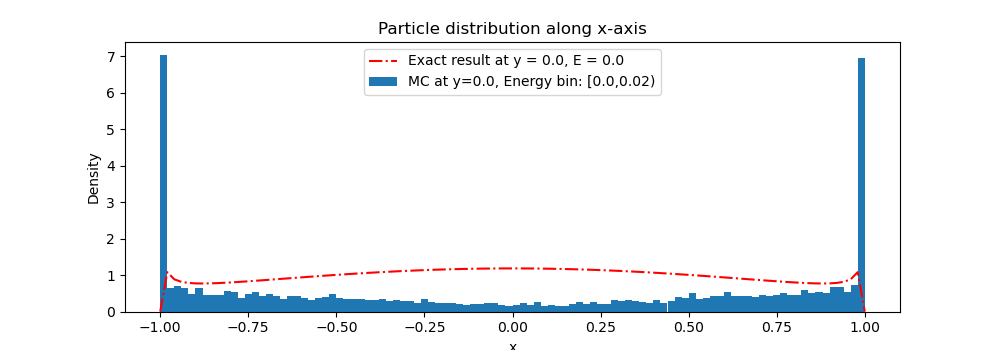

In [11]:
# End particle distribution along x-axis
ybin1Index = int((xbins)/2)

ybin1down = np.round(simDomain.yrange[ybin1Index], roundDigits)
ybin1up = np.round(simDomain.yrange[ybin1Index+1], roundDigits)

xFinalFluence = finalFluence[ybin1Index, :]
fig, ax1 = plt.subplots(figsize=(10, 3.5))
ax1.set_title('Particle distribution along x-axis')

dxMC = simDomain.xrange[1]-simDomain.xrange[0]
dxRes = xs[1] - xs[0]
ax1.bar(simDomain.xrange[:-1], xFinalFluence/(xFinalFluence.sum()*dxMC), align='edge', width=dxMC, 
        label=f'MC at y={np.round(simDomain.xrange[ybin1Index], roundDigits)}, Energy bin: [{bin2left},{bin2right})')
ax1.plot(xs, res[xSolIndex]*3, '-.r', label=f'Exact result at y = {np.round(xs[xSolIndex], roundDigits)}, E = 0.0')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()


In [12]:
middle = xFinalFluence[1:-1].sum()
ends = xFinalFluence[-1] + xFinalFluence[0]

print(middle/xFinalFluence.sum())
print(ends/xFinalFluence.sum())

0.7205642536166272
0.2794357463833726


Two sampling strategies for the angle

(array([516., 506., 513., 490., 510., 458., 482., 489., 530., 526., 502.,
        513., 469., 466., 490., 476., 501., 528., 521., 514.]),
 array([-9.99198393e-01, -8.99241338e-01, -7.99284282e-01, -6.99327227e-01,
        -5.99370171e-01, -4.99413116e-01, -3.99456061e-01, -2.99499005e-01,
        -1.99541950e-01, -9.95848946e-02,  3.72160828e-04,  1.00329216e-01,
         2.00286272e-01,  3.00243327e-01,  4.00200382e-01,  5.00157438e-01,
         6.00114493e-01,  7.00071549e-01,  8.00028604e-01,  8.99985659e-01,
         9.99942715e-01]),
 <BarContainer object of 20 artists>)

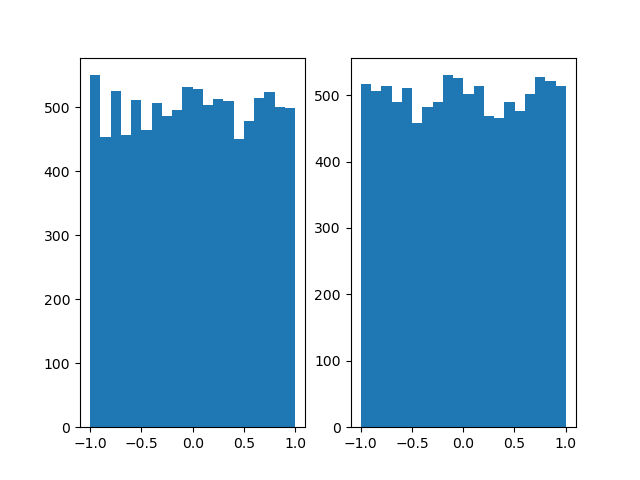

In [10]:
Nbsamples = 10000

# sample strategy 1
rs = np.random.uniform(size = Nbsamples)
theta = 2*np.arcsin(np.sqrt(rs))
mu1 = np.cos(theta)

# sample strategy 2
mu2 = np.random.uniform(low=-1, high=1, size = Nbsamples)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(mu1, bins = 20)
ax2.hist(mu2, bins = 20)